# Data Mining & Preprocessing:

## Kiểm tra cấu trúc dữ liệu (cột, kiểu dữ liệu, giá trị thiếu, phân phối).
- Xử lý dữ liệu thiếu hoặc không hợp lệ.
- Chuẩn hóa hoặc mã hóa các thuộc tính phù hợp.

## Tính Pearson Correlation:

- Tính hệ số tương quan Pearson giữa các thuộc tính và nhận xét.

## Áp dụng các thuật toán học máy:

- Chia tập dữ liệu thành tập huấn luyện và kiểm tra.
- Áp dụng một số thuật toán như Linear Regression, Decision Tree, Random Forest, và XGBoost.

## So sánh và lựa chọn thuật toán tốt nhất:

- So sánh dựa trên các chỉ số hiệu suất (MAE, MSE, R² đối với bài toán hồi quy hoặc accuracy, precision, recall nếu là bài toán phân loại).
- Chọn ra thuật toán tối ưu.

## Bước tiền xử lý dữ liệu.

In [33]:
import pandas as pd

# Import dataset
file_path = 'VN_housing_dataset.csv'
housing_data = pd.read_csv(file_path)

# Hiển thị thông số cơ bản của dataset và các dữ liệu đầu tiên trong tập dữ liệu
housing_data_info = housing_data.info()
housing_data_head = housing_data.head()

housing_data_info, housing_data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82496 entries, 0 to 82495
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       82496 non-null  int64 
 1   Ngày             82496 non-null  object
 2   Địa chỉ          82449 non-null  object
 3   Quận             82495 non-null  object
 4   Huyện            82449 non-null  object
 5   Loại hình nhà ở  82465 non-null  object
 6   Giấy tờ pháp lý  53610 non-null  object
 7   Số tầng          36399 non-null  object
 8   Số phòng ngủ     82458 non-null  object
 9   Diện tích        82495 non-null  object
 10  Dài              19827 non-null  object
 11  Rộng             35445 non-null  object
 12  Giá/m2           82484 non-null  object
dtypes: int64(1), object(12)
memory usage: 8.2+ MB


(None,
    Unnamed: 0      Ngày                                            Địa chỉ  \
 0           0  8/5/2020  Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...   
 1           1  8/5/2020  Đường Kim Giang, Phường Kim Giang, Quận Thanh ...   
 2           2  8/5/2020  phố minh khai, Phường Minh Khai, Quận Hai Bà T...   
 3           3  8/5/2020  Đường Võng Thị, Phường Thụy Khuê, Quận Tây Hồ,...   
 4           4  8/5/2020  Đường Kim Giang, Phường Kim Giang, Quận Thanh ...   
 
                 Quận             Huyện        Loại hình nhà ở Giấy tờ pháp lý  \
 0      Quận Cầu Giấy   Phường Nghĩa Đô           Nhà ngõ, hẻm        Đã có sổ   
 1    Quận Thanh Xuân  Phường Kim Giang  Nhà mặt phố, mặt tiền             NaN   
 2  Quận Hai Bà Trưng  Phường Minh Khai           Nhà ngõ, hẻm        Đã có sổ   
 3        Quận Tây Hồ  Phường Thụy Khuê           Nhà ngõ, hẻm        Đã có sổ   
 4    Quận Thanh Xuân  Phường Kim Giang           Nhà ngõ, hẻm             NaN   
 
   Số tầng Số phòng ngủ

In [34]:
# Hàm bỏ đơn vị trong dữ liệu
def remove_units(value):
    if pd.isna(value):
        return value
    
    # Convert giá trị thành dạng chuỗi và bỏ khoảng trắng
    value = str(value).strip()
    
    # Liệt kê các đơn vị cần bỏ
    units_to_remove = [
        'phòng', 
        'm²', 
        'm', 
        'triệu/m²',  # Đơn vị đầy đủ
        'triệu/',   # Phần đơn vị match 1 phần
        'đ/',
        '/m²'        # Phần đơn vị match 1 phần 
    ]
    
    for unit in units_to_remove:
        value = value.replace(unit, '').strip()
    
    return value

# Hàm xử lý cột PRICE
def process_price_column(value):
    if pd.isna(value):  # Kiểm tra giá trị NaN
        return None
    
    # Convert giá trị thành dạng chuỗi và bỏ khoảng trắng
    value = str(value).strip()
    
    # Xử lý trường hợp "tỷ/m²"
    if "tỷ/" in value:
        value = value.replace(",", ".").replace("tỷ/", "").strip()
        try:
            return float(value) * 1000  # Nhân với 1000 để chuyển từ tỷ/m² sang triệu/m²
        except ValueError:
            return None

    # Loại bỏ các ký tự không mong muốn trong PRICE
    value = value.replace(",", ".")
    
    try:
        # Chuyển đổi giá trị thành float
        value = float(value)
        # Xử lý các giá trị >= 50,000
        if value >= 50000:
            value = value / 1000  # Chuyển về triệu
        return value
    except ValueError:
        # Nếu không thể chuyển đổi, trả về None
        return None


# Chọn các cột cụ thể để xóa đơn vị
columns_to_clean = ['Số phòng ngủ', 'Diện tích', 'Dài', 'Rộng', 'Giá/m2']

# Áp dụng hàm xóa đơn vị vào các cột cụ thể đã chọn
for col in columns_to_clean:
    housing_data[col] = housing_data[col].apply(remove_units)

housing_data['Giá/m2'] = housing_data['Giá/m2'].apply(process_price_column)

# Hiển thị các dòng dữ liệu đầu tiên trong tập
housing_data.head()

,Unnamed: 0,Ngày,Địa chỉ,Quận,Huyện,Loại hình nhà ở,Giấy tờ pháp lý,Số tầng,Số phòng ngủ,Diện tích,Dài,Rộng,Giá/m2
0,0,8/5/2020,"Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...",Quận Cầu Giấy,Phường Nghĩa Đô,"Nhà ngõ, hẻm",Đã có sổ,4,5,46,NaN,NaN,86.96
1,1,8/5/2020,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà mặt phố, mặt tiền",NaN,NaN,3,37,NaN,NaN,116.22
2,2,8/5/2020,"phố minh khai, Phường Minh Khai, Quận Hai Bà T...",Quận Hai Bà Trưng,Phường Minh Khai,"Nhà ngõ, hẻm",Đã có sổ,4,4,40,10,4,65.00
3,3,8/5/2020,"Đường Võng Thị, Phường Thụy Khuê, Quận Tây Hồ,...",Quận Tây Hồ,Phường Thụy Khuê,"Nhà ngõ, hẻm",Đã có sổ,NaN,6,51,12.75,4,100.00
4,4,8/5/2020,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà ngõ, hẻm",NaN,NaN,4,36,9,4,86.11


In [35]:
# Tách cột "Ngày" thành các thành phần ngày, tháng, năm
housing_data[['DAY', 'MONTH', 'YEAR']] = housing_data['Ngày'].str.split('/', expand=True)

# Hoán đổi ngày và tháng
housing_data['Ngày'] = housing_data['MONTH'] + '/' + housing_data['DAY'] + '/' + housing_data['YEAR']

# Chuyển cột "Ngày" về kiểu datetime với định dạng đúng
housing_data['Ngày'] = pd.to_datetime(housing_data['Ngày'], format='%d/%m/%Y', errors='coerce')

# Kiểm tra kết quả
print(housing_data[['Ngày']].tail())

            Ngày
82491 2019-08-23
82492 2019-08-07
82493 2019-08-07
82494 2019-08-05
82495 2019-08-05


In [36]:
# Trích xuất các thành phần từ cột "Ngày"
housing_data['DAY_OF_WEEK'] = housing_data['Ngày'].dt.day_name()
housing_data['WEEK_OF_YEAR'] = housing_data['Ngày'].dt.isocalendar().week
housing_data['DAY'] = housing_data['Ngày'].dt.day
housing_data['MONTH'] = housing_data['Ngày'].dt.month
housing_data['QUARTER'] = housing_data['Ngày'].dt.quarter
housing_data['YEAR'] = housing_data['Ngày'].dt.year


housing_data[['Ngày', 'DAY_OF_WEEK', 'WEEK_OF_YEAR', 'DAY', 'MONTH', 'QUARTER', 'YEAR']].tail()

,Ngày,DAY_OF_WEEK,WEEK_OF_YEAR,DAY,MONTH,QUARTER,YEAR
82491,2019-08-23,Friday,34,23,8,3,2019
82492,2019-08-07,Wednesday,32,7,8,3,2019
82493,2019-08-07,Wednesday,32,7,8,3,2019
82494,2019-08-05,Monday,32,5,8,3,2019
82495,2019-08-05,Monday,32,5,8,3,2019


In [37]:
housing_data['DAY'] = housing_data['DAY'].fillna(0).astype(int)
housing_data['MONTH'] = housing_data['MONTH'].fillna(0).astype(int)
housing_data['QUARTER'] = housing_data['QUARTER'].fillna(0).astype(int)
housing_data['YEAR'] = housing_data['YEAR'].fillna(0).astype(int)

housing_data[['Ngày', 'DAY_OF_WEEK', 'WEEK_OF_YEAR', 'DAY', 'MONTH', 'QUARTER', 'YEAR']].head()

,Ngày,DAY_OF_WEEK,WEEK_OF_YEAR,DAY,MONTH,QUARTER,YEAR
0,2020-08-05,Wednesday,32,5,8,3,2020
1,2020-08-05,Wednesday,32,5,8,3,2020
2,2020-08-05,Wednesday,32,5,8,3,2020
3,2020-08-05,Wednesday,32,5,8,3,2020
4,2020-08-05,Wednesday,32,5,8,3,2020


In [38]:
# Loại bỏ các dòng giá trị có thể gây ảnh hưởng đến quá trình Data Mining
invalid_addresses = [
    "Đường Huyền Kỳ, Phường Phú Lãm, Quận Hà Đông, Hà Nội",
    "Bán nhà Đường Kim Ngưu - Quận Hai Bà Trưng - Hà Nội, Phường Quỳnh Mai, Quận Hai Bà Trưng, Hà Nội",
    "Đường Yên Lãng, Phường Láng Hạ, Quận Đống Đa, Hà Nội",
    "Đường Vân Hồ 3, Phường Lê Đại Hành, Quận Hai Bà Trưng, Hà Nội",
    "Đường Yên Lãng, Phường Trung Liệt, Quận Đống Đa, Hà Nội"
]

# Lọc bỏ các dòng giá trị có mặt trong danh sách invalid_addresses
housing_data = housing_data[~housing_data['Địa chỉ'].isin(invalid_addresses)]

# Hiển thị "Địa chỉ" mới
housing_data[['Địa chỉ']].head()

,Địa chỉ
0,"Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C..."
1,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ..."
2,"phố minh khai, Phường Minh Khai, Quận Hai Bà T..."
3,"Đường Võng Thị, Phường Thụy Khuê, Quận Tây Hồ,..."
4,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ..."


In [39]:
import numpy as np

# Hàm trích xuất thành phần ROAD từ "Địa chỉ"
def extract_road(address):
    if pd.isna(address) or "Đường" not in address:
        return "UNKNOWN"
    start_idx = address.find("Đường")
    end_idx = address.find(", Phường") if ", Phường" in address else address.find(", Xã")
    if end_idx == -1:
        return "UNKNOWN"
    return address[start_idx:end_idx].strip()

# Trích xuất ROAD, WARD, DISTRICT, và gán giá trị cho PROVINCE
housing_data['ROAD'] = housing_data['Địa chỉ'].apply(extract_road)
housing_data['WARD'] = housing_data['Huyện']
housing_data['DISTRICT'] = housing_data['Quận']
housing_data['PROVINCE'] = "Hà Nội"

housing_data[['Địa chỉ', 'ROAD', 'WARD', 'DISTRICT', 'PROVINCE']].head()

,Địa chỉ,ROAD,WARD,DISTRICT,PROVINCE
0,"Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...",Đường Hoàng Quốc Việt,Phường Nghĩa Đô,Quận Cầu Giấy,Hà Nội
1,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Đường Kim Giang,Phường Kim Giang,Quận Thanh Xuân,Hà Nội
2,"phố minh khai, Phường Minh Khai, Quận Hai Bà T...",UNKNOWN,Phường Minh Khai,Quận Hai Bà Trưng,Hà Nội
3,"Đường Võng Thị, Phường Thụy Khuê, Quận Tây Hồ,...",Đường Võng Thị,Phường Thụy Khuê,Quận Tây Hồ,Hà Nội
4,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Đường Kim Giang,Phường Kim Giang,Quận Thanh Xuân,Hà Nội


### Kiểm tra giá trị các cột và sửa lỗi nếu cần


In [40]:
# Phân tích cột TYPE_OF_HOUSING
housing_data['TYPE_OF_HOUSING'] = housing_data['Loại hình nhà ở']

# Phân tích cột NUMBER_OF_FLOORS
def process_number_of_floors(value):
    if pd.isna(value) or not str(value).isdigit():
        return None  # Thay thế các dòng giá trị bị NA hoặc sai
    value = int(value)
    return value if value <= 10 else None  # Loại trừ các dòng dữ liệu có số tầng lớn hơn 10

housing_data['NUMBER_OF_FLOORS'] = housing_data['Số tầng'].apply(process_number_of_floors).fillna(0).astype(int)

# Biến đổi giá trị 0 thành NaN (NULL)
housing_data['NUMBER_OF_FLOORS'] = housing_data['NUMBER_OF_FLOORS'].replace(0, None)

# Phân tích cột NUMBER_OF_BEDROOMS
def process_number_of_bedrooms(value):
    value = str(value).strip().lower()
    if "nhiều hơn 10" in value:
        return 11
    if value.isdigit():
        value = int(value)
        return value if value <= 10 else None
    return None  # Thay thế các dòng dữ liệu bị sai hoặc không phải dạng số 

housing_data['NUMBER_OF_BEDROOMS'] = housing_data['Số phòng ngủ'].apply(process_number_of_bedrooms).fillna(0).astype(int)

# Thêm cột "PAPERS" từ cột "Giấy tờ pháp lý"
housing_data['PAPERS'] = housing_data['Giấy tờ pháp lý'].apply(lambda x: "Chưa có" if pd.isna(x) else x)

# Hiển thị các cột vừa phân tích
housing_data[['TYPE_OF_HOUSING', 'NUMBER_OF_FLOORS', 'NUMBER_OF_BEDROOMS', 'PAPERS']].head(10)


,TYPE_OF_HOUSING,NUMBER_OF_FLOORS,NUMBER_OF_BEDROOMS,PAPERS
0,"Nhà ngõ, hẻm",4,5,Đã có sổ
1,"Nhà mặt phố, mặt tiền",None,3,Chưa có
2,"Nhà ngõ, hẻm",4,4,Đã có sổ
3,"Nhà ngõ, hẻm",None,6,Đã có sổ
4,"Nhà ngõ, hẻm",None,4,Chưa có
5,"Nhà ngõ, hẻm",None,11,Đã có sổ
6,"Nhà ngõ, hẻm",None,3,Chưa có
7,"Nhà mặt phố, mặt tiền",6,5,Đã có sổ
8,"Nhà ngõ, hẻm",None,4,Chưa có
9,"Nhà ngõ, hẻm",4,3,Đã có sổ


### Kiểm tra giá trị các cột và sửa lỗi nếu cần


In [41]:
# Sửa tên các cột "Diện tích", "Dài", "Rộng", "Giá/m2"
# Loại bỏ các cột "Ngày", "Địa chỉ"
columns_to_rename = {
    "Diện tích" : "AREA",
    "Dài": "LONG", 
    "Rộng": "WIDTH",
    "Giá/m2": "PRICE"
}
housing_data.rename(columns=columns_to_rename, inplace= True)

columns_to_drop = ["Ngày", "Địa chỉ", 'Quận', 'Huyện', 'Loại hình nhà ở', 'Giấy tờ pháp lý', "Unnamed: 0",
       'Số tầng', 'Số phòng ngủ']
housing_data.drop(columns=columns_to_drop, inplace= True)

housing_data = housing_data.where(pd.notnull(housing_data), None)

housing_data.head()


,AREA,LONG,WIDTH,PRICE,DAY,MONTH,YEAR,DAY_OF_WEEK,WEEK_OF_YEAR,QUARTER,ROAD,WARD,DISTRICT,PROVINCE,TYPE_OF_HOUSING,NUMBER_OF_FLOORS,NUMBER_OF_BEDROOMS,PAPERS
0,46,None,None,86.96,5,8,2020,Wednesday,32,3,Đường Hoàng Quốc Việt,Phường Nghĩa Đô,Quận Cầu Giấy,Hà Nội,"Nhà ngõ, hẻm",4,5,Đã có sổ
1,37,None,None,116.22,5,8,2020,Wednesday,32,3,Đường Kim Giang,Phường Kim Giang,Quận Thanh Xuân,Hà Nội,"Nhà mặt phố, mặt tiền",None,3,Chưa có
2,40,10,4,65.00,5,8,2020,Wednesday,32,3,UNKNOWN,Phường Minh Khai,Quận Hai Bà Trưng,Hà Nội,"Nhà ngõ, hẻm",4,4,Đã có sổ
3,51,12.75,4,100.00,5,8,2020,Wednesday,32,3,Đường Võng Thị,Phường Thụy Khuê,Quận Tây Hồ,Hà Nội,"Nhà ngõ, hẻm",None,6,Đã có sổ
4,36,9,4,86.11,5,8,2020,Wednesday,32,3,Đường Kim Giang,Phường Kim Giang,Quận Thanh Xuân,Hà Nội,"Nhà ngõ, hẻm",None,4,Chưa có


### Xuất dữ liệu đã tiền xử lý ra file CSV mới


In [42]:
# Xuất dữ liệu đã tiền xử lý ra file CSV mới
output_file_path = 'processed_VN_housing_dataset.csv'
housing_data.to_csv(output_file_path, index=False)

print(f"Dữ liệu đã được xử lý và lưu tại: {output_file_path}")
housing_data.head(10)

Dữ liệu đã được xử lý và lưu tại: processed_VN_housing_dataset.csv


,AREA,LONG,WIDTH,PRICE,DAY,MONTH,YEAR,DAY_OF_WEEK,WEEK_OF_YEAR,QUARTER,ROAD,WARD,DISTRICT,PROVINCE,TYPE_OF_HOUSING,NUMBER_OF_FLOORS,NUMBER_OF_BEDROOMS,PAPERS
0,46,None,None,86.96,5,8,2020,Wednesday,32,3,Đường Hoàng Quốc Việt,Phường Nghĩa Đô,Quận Cầu Giấy,Hà Nội,"Nhà ngõ, hẻm",4,5,Đã có sổ
1,37,None,None,116.22,5,8,2020,Wednesday,32,3,Đường Kim Giang,Phường Kim Giang,Quận Thanh Xuân,Hà Nội,"Nhà mặt phố, mặt tiền",None,3,Chưa có
2,40,10,4,65.00,5,8,2020,Wednesday,32,3,UNKNOWN,Phường Minh Khai,Quận Hai Bà Trưng,Hà Nội,"Nhà ngõ, hẻm",4,4,Đã có sổ
3,51,12.75,4,100.00,5,8,2020,Wednesday,32,3,Đường Võng Thị,Phường Thụy Khuê,Quận Tây Hồ,Hà Nội,"Nhà ngõ, hẻm",None,6,Đã có sổ
4,36,9,4,86.11,5,8,2020,Wednesday,32,3,Đường Kim Giang,Phường Kim Giang,Quận Thanh Xuân,Hà Nội,"Nhà ngõ, hẻm",None,4,Chưa có
5,46,12.1,3.8,104.35,5,8,2020,Wednesday,32,3,Đường Yên Hòa,Phường Yên Hoà,Quận Cầu Giấy,Hà Nội,"Nhà ngõ, hẻm",None,11,Đã có sổ
6,52,None,4.5,112.50,5,8,2020,Wednesday,32,3,Đường Tây Sơn,Phường Trung Liệt,Quận Đống Đa,Hà Nội,"Nhà ngõ, hẻm",None,3,Chưa có
7,32,None,6.8,184.38,5,8,2020,Wednesday,32,3,Đường Lò Đúc,Phường Đống Mác,Quận Hai Bà Trưng,Hà Nội,"Nhà mặt phố, mặt tiền",6,5,Đã có sổ
8,75,12,6.5,120.00,5,8,2020,Wednesday,32,3,Đường Xuân La,Phường Xuân La,Quận Tây Hồ,Hà Nội,"Nhà ngõ, hẻm",None,4,Chưa có
9,41,None,3.5,64.63,5,8,2020,Wednesday,32,3,Đường 19/5,Phường Văn Quán,Quận Hà Đông,Hà Nội,"Nhà ngõ, hẻm",4,3,Đã có sổ


## Tính Pearson Correlation:

- Tính hệ số tương quan Pearson giữa các thuộc tính và nhận xét.


### Hệ số tương quan Pearson giúp đánh giá mối liên hệ tuyến tính giữa các cặp thuộc tính. Chúng ta sẽ:

- Loại bỏ các giá trị NULL hoặc thay thế bằng giá trị trung bình/median (nếu phù hợp).
- Chỉ chọn các cột số để tính toán.
- Tính ma trận tương quan Pearson và trực quan hóa bằng heatmap.

In [43]:
# Kiểm tra giá trị bị thiếu
missing_values = housing_data.isnull().sum()

# Chỉ giữ các cột liên tục để tính hệ số tương quan Pearson
continuous_columns = ['AREA', 'LONG', 'WIDTH', 'PRICE', 'NUMBER_OF_FLOORS', 'NUMBER_OF_BEDROOMS']
correlation_data = housing_data[continuous_columns]

# Xử lý dữ liệu bị thiếu bằng cách loại bỏ các hàng bị thiếu ở các cột liên tục
correlation_data = correlation_data.dropna()

# Tính hệ số tương quan Pearson
correlation_matrix = correlation_data.corr()

missing_values, correlation_matrix


(AREA                      1
 LONG                  62663
 WIDTH                 47046
 PRICE                    15
 DAY                       0
 MONTH                     0
 YEAR                      0
 DAY_OF_WEEK               0
 WEEK_OF_YEAR              0
 QUARTER                   0
 ROAD                      0
 WARD                     47
 DISTRICT                  1
 PROVINCE                  0
 TYPE_OF_HOUSING          31
 NUMBER_OF_FLOORS      46134
 NUMBER_OF_BEDROOMS        0
 PAPERS                    0
 dtype: int64,
                         AREA      LONG     WIDTH     PRICE  NUMBER_OF_FLOORS  \
 AREA                1.000000  0.037575  0.080616  0.010163         -0.008281   
 LONG                0.037575  1.000000  0.484687 -0.003832         -0.000762   
 WIDTH               0.080616  0.484687  1.000000 -0.004223         -0.007856   
 PRICE               0.010163 -0.003832 -0.004223  1.000000          0.163505   
 NUMBER_OF_FLOORS   -0.008281 -0.000762 -0.007856  0.16350

<h3> Kết quả kiểm tra dữ liệu: </h3>

- Các cột chứa giá trị bị thiếu đáng kể:

    - **LONG**: 62,663 giá trị bị thiếu.
    - **WIDTH**: 47,046 giá trị bị thiếu.
    - **NUMBER_OF_FLOORS**: 46,134 giá trị bị thiếu.

- Một số cột có ít giá trị bị thiếu (**AREA**, **DISTRICT**, **TYPE_OF_HOUSING**).

<h3> Kết quả tính hệ số tương quan Pearson: </h3>

|Thuộc tính| AREA   | LONG | WIDTH | PRICE | NUMBER_OF_FLOORS | NUMBER_OF_BEDROOMS |
|:---------|:--------:|:--------:|---------:|:---------:|:--------:|:---------:|
| PRICE  | 0.01   | -0.0038 | -0.0042   |  1.0   |  0.1635  | 0.1480|

- Hệ số tương quan giữa PRICE và các thuộc tính khác:

    - Yếu, nhưng có tương quan dương đáng kể với NUMBER_OF_FLOORS (0.16) và NUMBER_OF_BEDROOMS (0.15).
    - Gần như không có tương quan với các cột còn lại.

<H3>Thực hiện chuẩn hóa các cột dữ liệu </H3>

1. Loại bỏ cột LONG và WIDTH:

    - Vì cả hai cột này có trên 70% giá trị bị thiếu và tương quan rất thấp với PRICE.
2. Điền giá trị bị thiếu cho NUMBER_OF_FLOORS:

    - Dùng trung vị (median) vì đây là dữ liệu liên tục và thường phân bố không chuẩn.
3. Giữ lại các cột còn lại, nhưng loại bỏ hàng có quá nhiều giá trị NULL (>50% cột bị thiếu):

    - Điều này sẽ giảm thiểu mất mát thông tin trong khi vẫn giữ chất lượng dữ liệu.

In [44]:
# Loại bỏ các cột có nhiều giá trị NULL và ít ảnh hưởng tới mục tiêu
housing_data_cleaned = housing_data.drop(columns=['LONG', 'WIDTH'])

# Điền giá trị bị thiếu cho cột "NUMBER_OF_FLOORS" bằng giá trị trung vị sàn
median_floors = housing_data_cleaned['NUMBER_OF_FLOORS'].median()
housing_data_cleaned['NUMBER_OF_FLOORS'].fillna(median_floors, inplace=True)

# Loại bỏ các hàng có quá nhiều giá trị NULL (>50% cột bị thiếu)
threshold = len(housing_data_cleaned.columns) / 2
housing_data_cleaned = housing_data_cleaned.dropna(thresh=threshold, axis=0)

# Kiểm tra lại dữ liệu sau khi xử lý
missing_values_after_cleaning = housing_data_cleaned.isnull().sum()
housing_data_cleaned.head(), missing_values_after_cleaning

output_file_path_cleaned = 'cleaned_data.csv'
housing_data_cleaned.to_csv(output_file_path_cleaned, index=False)


C:\Users\tuant\AppData\Local\Temp\ipykernel_7180\857462339.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing_data_cleaned['NUMBER_OF_FLOORS'].fillna(median_floors, inplace=True)
C:\Users\tuant\AppData\Local\Temp\ipykernel_7180\857462339.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  housing_data_

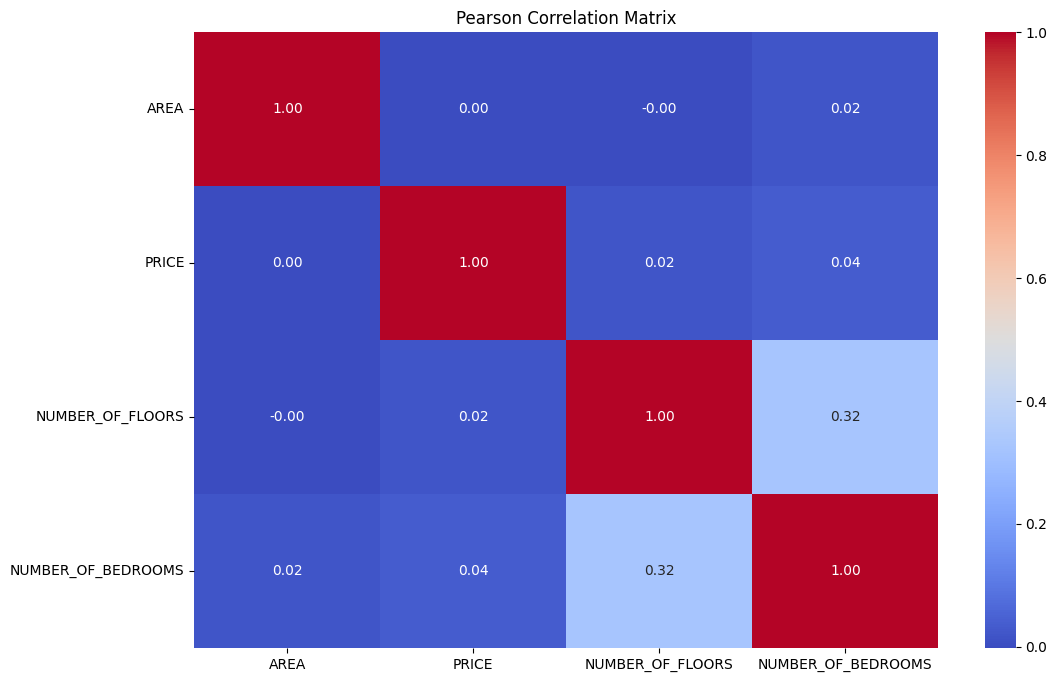

Nhận xét về hệ số tương quan Pearson:
Hệ số tương quan giữa PRICE và AREA: 0.00
Hệ số tương quan giữa PRICE và NUMBER_OF_FLOORS: 0.02
Hệ số tương quan giữa PRICE và NUMBER_OF_BEDROOMS: 0.04


In [47]:
import seaborn as sns

import matplotlib.pyplot as plt

continuous_columns = ['AREA', 'PRICE', 'NUMBER_OF_FLOORS', 'NUMBER_OF_BEDROOMS']

# Tính ma trận tương quan Pearson
correlation_matrix = housing_data_cleaned[continuous_columns].corr()

# Hiển thị ma trận tương quan
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

# Nhận xét
print("Nhận xét về hệ số tương quan Pearson:")
for col in correlation_matrix.columns:
    if col != 'PRICE':
        print(f"Hệ số tương quan giữa PRICE và {col}: {correlation_matrix.at['PRICE', col]:.2f}")

## Áp dụng các thuật toán học máy:

- Chia tập dữ liệu thành tập huấn luyện và kiểm tra.
- Áp dụng một số thuật toán như Linear Regression, Decision Tree, Random Forest, và XGBoost.


In [ ]:
%pip install scikit-learn xgboost numpy pandas

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at d:\tools\python\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [ ]:
# Xử lý giá trị bị thiếu còn lại: Loại bỏ các hàng có NULL trong các cột quan trọng (PRICE và AREA)
housing_data_ml = housing_data_cleaned.dropna()

# Apply One-Hot Encoding to categorical columns
categorical_columns = [
    "DAY_OF_WEEK", "ROAD", "WARD", "DISTRICT", "PROVINCE", "TYPE_OF_HOUSING", "PAPERS"
]
housing_data_ml = pd.get_dummies(housing_data_ml, columns=categorical_columns, drop_first=True)

# Chuyển đổi tất cả các cột sang kiểu số
housing_data_ml = housing_data_ml.apply(pd.to_numeric, errors='coerce')

# Kiểm tra và xử lý lại các giá trị null sau khi chuyển đổi (nếu có)
housing_data_ml = housing_data_ml.dropna()

# Tách dữ liệu thành X (đặc trưng) và y (mục tiêu)
X = housing_data_ml.drop(columns=['PRICE'])
y = housing_data_ml['PRICE']

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo các mô hình
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=100, use_label_encoder=False, eval_metric='rmse')
}

# Huấn luyện và đánh giá từng mô hình
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R²": r2_score(y_test, y_pred)
    }

# In kết quả
print(results)

d:\TOOLS\Python\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'Linear Regression': {'MAE': 56.49808764675953, 'MSE': 43580.48773152622, 'R²': -0.3957441104567285}, 'Decision Tree': {'MAE': 46.44723098248382, 'MSE': 653531.2257163825, 'R²': -19.93052204721765}, 'Random Forest': {'MAE': 39.59202470477496, 'MSE': 242270.55946235117, 'R²': -6.759153788956256}, 'XGBoost': {'MAE': 43.845468236848674, 'MSE': 415071.1030838377, 'R²': -12.293404404259416}}



## So sánh và lựa chọn thuật toán tốt nhất:

- So sánh dựa trên các chỉ số hiệu suất (MAE, MSE, R² đối với bài toán hồi quy hoặc accuracy, precision, recall nếu là bài toán phân loại).
- Chọn ra thuật toán tối ưu.

So sánh hiệu suất của các mô hình:
                         MAE            MSE         R²
Linear Regression  56.498088   43580.487732  -0.395744
Decision Tree      46.447231  653531.225716 -19.930522
Random Forest      39.592025  242270.559462  -6.759154
XGBoost            43.845468  415071.103084 -12.293404

Mô hình tốt nhất là: Random Forest
Hiệu suất của mô hình tốt nhất:
MAE: 39.5920
MSE: 242270.5595
R²: -6.7592


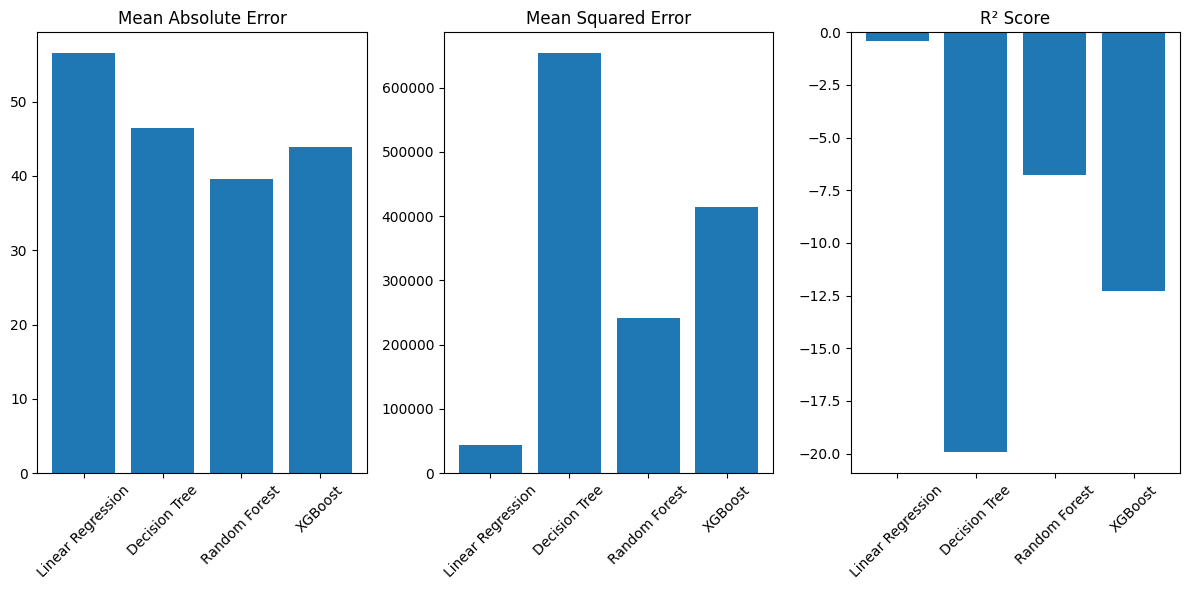

In [ ]:
import matplotlib.pyplot as plt

# Chuyển đổi results dictionary thành DataFrame với cấu trúc phù hợp
results_df = pd.DataFrame.from_dict(results, orient='index')

# Hiển thị kết quả
print("So sánh hiệu suất của các mô hình:")
print(results_df)

# Chọn mô hình tốt nhất dựa trên MAE thấp nhất
best_model_name = results_df['MAE'].idxmin()
best_model_performance = results_df.loc[best_model_name]

print(f"\nMô hình tốt nhất là: {best_model_name}")
print(f"Hiệu suất của mô hình tốt nhất:")
for metric, value in best_model_performance.items():
    print(f"{metric}: {value:.4f}")

# Tạo một biểu đồ so sánh các metrics
plt.figure(figsize=(12, 6))

# Plot MAE
plt.subplot(131)
plt.bar(results_df.index, results_df['MAE'])
plt.title('Mean Absolute Error')
plt.xticks(rotation=45)

# Plot MSE
plt.subplot(132)
plt.bar(results_df.index, results_df['MSE'])
plt.title('Mean Squared Error')
plt.xticks(rotation=45)

# Plot R²
plt.subplot(133)
plt.bar(results_df.index, results_df['R²'])
plt.title('R² Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()